In [1]:
import sys
import re
from pathlib import Path

import numpy as np
from scipy.optimize import curve_fit, minimize

from glob import glob
from natsort import natsort

from matplotlib import pyplot as plt

sys.path.append('/Users/tjlane/opt/mmcpd-scripts/')
import models

## publication-quality graphs of the power titration done in Feb 2022

A note on "photons per molecule"

From Branden and Neutze:

F = mean fluence
N_A = Avogadro's number

photons per molecule --> sigma * F / hv

sigma = epsilon * 1000 * ln(10) / N_A

In [2]:
FOCUS_SIZE = (180.0, 170.0)  # microns
PULSE_DURATION = 100e-15     # seconds
REP_RATE_HZ    = 1500.0      # pulses per second
TRANSMISSION   = 0.66
WAVELENGTH_SLICE = np.s_[235:325]  # np.s_[240:320]
WAVELENGTH_SLICE_REFERENCE = np.s_[1240 + 236:1240 + 315]

AVOGADRO = 6.02214076e23 * 1e-3 # mol / cm3
EPSILON = 3414.0 # 1/mol 1/cm
HV = 4.9661142113759e-19 # J, for a 400 nm photon


In [3]:
raw_data = {}
for raw_data_file in glob('../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd*__bgsubstracted.dat'):
    power_group = re.search('mmcpd_15uM_(\d+)mW__bgsubstracted.dat', Path(raw_data_file).name)
    power = float(power_group.group(1))

    if power != 5.0:
        raw_data[power] = raw_data_file

raw_data

{21.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_21mW__bgsubstracted.dat',
 3.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_3mW__bgsubstracted.dat',
 6.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_6mW__bgsubstracted.dat',
 9.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_9mW__bgsubstracted.dat',
 2.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_2mW__bgsubstracted.dat',
 4.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_4mW__bgsubstracted.dat',
 1.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_1mW__bgsubstracted.dat',
 14.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_14mW__bgsubstracted.dat',
 43.0: '../mmCPD_TA_feb2022_data/220223_powerseries_measurements/mmcpd_15uM_43mW__bgsubstracted.dat'}

In [4]:
def load_raw(power, data_slice=np.s_[:]):
    """ returns (times, delta_absorbances) """
    d = np.genfromtxt( raw_data[power] )
    d = np.nan_to_num(d)
    return d[1:,0], d[1:,data_slice]


def power_to_peak_powers(power):
    const = np.power(2*np.sqrt(np.log(2) / np.pi), 3)
    power_factor = power / (REP_RATE_HZ * np.product(FOCUS_SIZE) * PULSE_DURATION)
    power_factor = 1e-4 * power_factor # mW/um2 --> GW/cm2
    return TRANSMISSION * const * power_factor


def average_power_to_photons_per_molecule(peak_power):
    # start: GW / cm2
    fluence = 1.64 * PULSE_DURATION * peak_power * 1e9 # J / cm2
    sigma = EPSILON * np.log(10) / AVOGADRO # cm2
    return fluence * sigma / HV # unitless


def transmission_correction_factor(transmission):
    return - (1.0 - transmission) / np.log(transmission)


def standard_err(x):
    return np.sqrt(np.sum(np.square(x - x.mean(axis=0)), axis=0)) / float(x.shape[0])

## wavelength calibration

due to experimental difficulties, we do not have the wavelength axis for this experiment

instead, use Dec 2021 data as a calibration

we'll fit the Dec 2021 to a spline, $s_{ref} (\lambda)$, then fit a polynomial $f_\theta (\mathrm{index}) = \lambda$ such that

$$
\min_\theta || s( f[i] ) - s_{ref} (\lambda) ||^2
$$

In [6]:
# pick a reference dataset
REF_D_SLICE = np.s_[210:320] # a shorthand for cutting the useful wavelengths out of the data

ref_file = '../mmCPD_TA_dec2021_data/without_dna/mmcpd_noDNA_2mW_bgsubstracted.dat'

ref_raw = np.nan_to_num( np.genfromtxt(ref_file) )
ref_times = ref_raw[1:,0]
ref_data  = ref_raw[:,REF_D_SLICE]
ref_wavelengths = np.genfromtxt('../mmCPD_TA_dec2021_data/Wavelengths.txt')[1,REF_D_SLICE] * 1000.0

REF_TIME_INDEX = 311
print('reference delta t:', ref_times[REF_TIME_INDEX])


reference delta t: 20000.0


In [7]:
TARGET_TIME_INDEX = 11
CALIBRATION_WAVELENGTH_SLICE = np.s_[240:320]
target_times, target_data = load_raw(2.0, CALIBRATION_WAVELENGTH_SLICE)

TARGET_INDICES = np.arange(len(target_data[TARGET_TIME_INDEX,1:]))

print('target delta t:', target_times[TARGET_TIME_INDEX])

target delta t: 19998.0


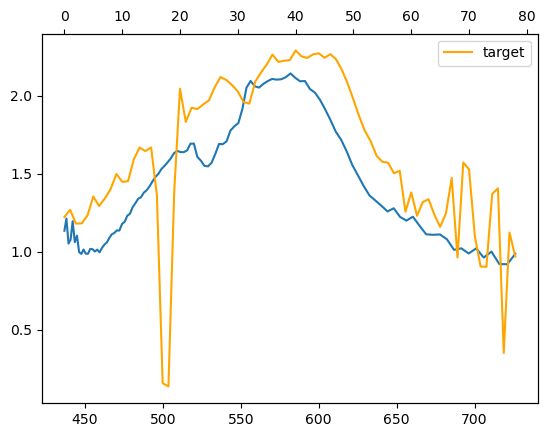

In [8]:
plt.figure()
ax = plt.subplot(111)
pr = ax.plot(ref_wavelengths, ref_data[REF_TIME_INDEX,:], label='reference')
ax2 = plt.twiny()
pt = ax2.plot(TARGET_INDICES, target_data[TARGET_TIME_INDEX,1:], color='orange', label='target')
plt.legend()
plt.show()

In [9]:
def target_absorbance(wavelength):
    return np.interp(wavelength, ref_wavelengths, ref_data[REF_TIME_INDEX,:])


def objective(z, lcut=0):
    index_mapping = np.poly1d(z)
    guessed_wavelengths = index_mapping(TARGET_INDICES)
    s_hat = target_absorbance(guessed_wavelengths)
    s_hat_norm = s_hat[lcut:] / np.max(s_hat[lcut:])
    td_norm = target_data[TARGET_TIME_INDEX,1+lcut:] / np.max(target_data[TARGET_TIME_INDEX,1+lcut:])
    return np.sum(np.square(s_hat_norm - td_norm))

z0 = (1.0, 500.0)

m_opt = minimize(objective, x0=z0)
print(m_opt)

z_opt = m_opt.x

      fun: 1.4478260804369805
 hess_inv: array([[ 2.04553711e-01, -6.19473530e+00],
       [-6.19473530e+00,  2.23427487e+02]])
      jac: array([0.50051299, 0.01086523])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 197
      nit: 10
     njev: 63
   status: 2
  success: False
        x: array([  2.70453018, 476.57987162])


In [10]:
wl_mapping = np.poly1d(z_opt)
WAVELENGTHS = wl_mapping(TARGET_INDICES)

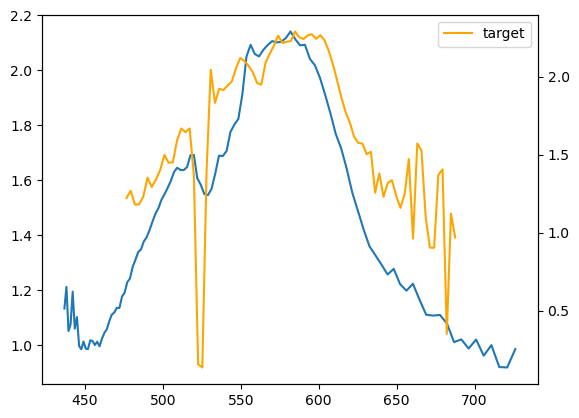

In [11]:
plt.figure()
ax = plt.subplot(111)
pr = ax.plot(ref_wavelengths, ref_data[REF_TIME_INDEX,:], label='reference')
ax2=ax.twinx()
pt = ax2.plot(wl_mapping(TARGET_INDICES), target_data[TARGET_TIME_INDEX,1:], color='orange', label='target')
plt.legend()
plt.show()

## plot the results

To Do for the below:
* calibrate the wavelengths
* put the power units in GW/cm2

In [12]:
powers = sorted(raw_data.keys())

powers_in_GWcm2 = [ power_to_peak_powers(p) for p in powers ]
photons_per_moleclue = [ average_power_to_photons_per_molecule(p) for p in powers_in_GWcm2 ]

power_colors = plt.cm.winter(np.linspace(0, 1, len(powers)))

expntl_t0 = lambda t,a,b: a * np.exp(-b * t)
p_ini = (1.0, 1e-6)

print(powers_in_GWcm2)

[11.921602016775871, 23.843204033551743, 35.764806050327614, 47.686408067103486, 71.52961210065523, 107.29441815098285, 166.9024282348622, 250.35364235229326, 512.6288867213624]


residual: 1.1119554858064802


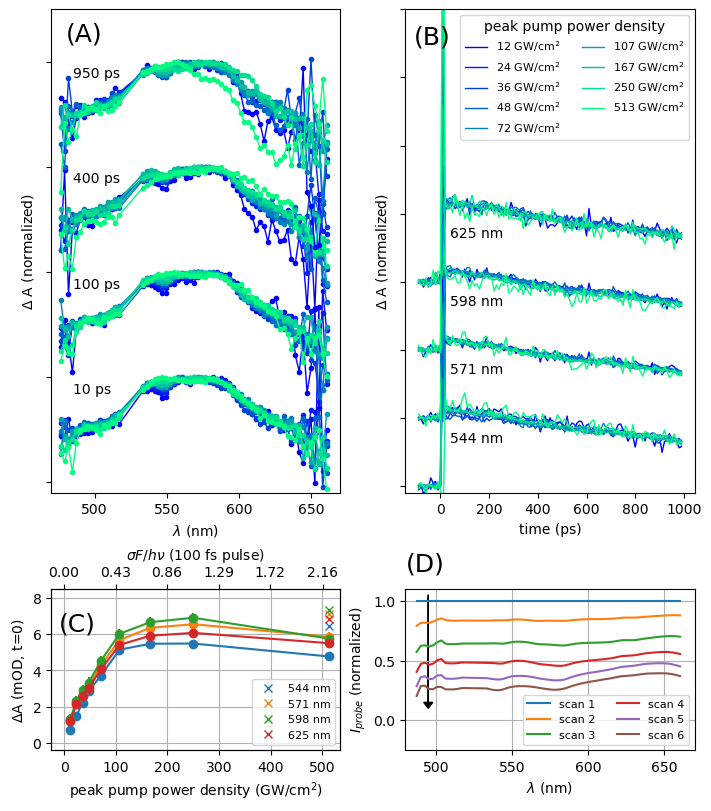

In [21]:
PLOT_WAVELENGTH_CUT = np.array(list(range(16)) + list(range(-58,-10)))

fig = plt.figure(figsize=(7,8), constrained_layout=True)
gs = fig.add_gridspec(4, 2)


ax1 = fig.add_subplot(gs[:3,0])
timepoint_indices = [11, 20, 50, 105]

for ix, timepoint_index in enumerate(timepoint_indices):
    for ip, power in enumerate(powers):

        times, dAs = load_raw(power, WAVELENGTH_SLICE)

        if ip == 0:
            time_delay = times[timepoint_index] - 10000.0 # t0 offset
            display_string = str(round(time_delay / 1000.0)) + ' ps'
            ax1.text(485, 0.85 + ix, display_string)

        delta_A = dAs[timepoint_index,1:] / np.max(dAs[timepoint_index,30:70])

        sem_A = standard_err(dAs[:9,1:] / np.max(dAs[:9,30:70]))
        #print(ip, power, np.mean(delta_A/sem_A))

        plot_amps = delta_A + ix
        ax1.plot(
            WAVELENGTHS[PLOT_WAVELENGTH_CUT],
            plot_amps[PLOT_WAVELENGTH_CUT], 
            '.',
            color=power_colors[ip]
        )
        ax1.plot(
            WAVELENGTHS[PLOT_WAVELENGTH_CUT],
            plot_amps[PLOT_WAVELENGTH_CUT],
            linewidth=1,
            color=power_colors[ip],
            label='_nolegend_'
        )
        # if ip == 0:
        #     ax1.fill_between(
        #         WAVELENGTHS[PLOT_WAVELENGTH_CUT],
        #         plot_amps[PLOT_WAVELENGTH_CUT] - sem_A[PLOT_WAVELENGTH_CUT] * 1.96,
        #         plot_amps[PLOT_WAVELENGTH_CUT] + sem_A[PLOT_WAVELENGTH_CUT] * 1.96,
        #         alpha=0.2,
        #         color='grey',
        #         label='_nolegend_'
        #     )

ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel(r'$\Delta$ A (normalized)')

ax1.set_ylim([-0.1, ix + 1.5])
ax1.set_xlim([470, 670])
ax1.set_yticklabels([])

ax1.text(480, ix + 1.2, '(A)', fontsize=18)

# ----------------------------

ax2 = fig.add_subplot(gs[:3,1])
wavelength_indices = [25, 35, 45, 55]

for ix, wl_index in enumerate(wavelength_indices):
    for ip, power in enumerate(powers):

        times, dAs = load_raw(power, WAVELENGTH_SLICE)

        delta_A = dAs[:,wl_index] / ( np.mean(dAs[:,wl_index]) * 1.2 )
        plot_amps = delta_A + ix

        if ip == 0:
            wl = WAVELENGTHS[wl_index]
            display_string = str(round(wl)) + ' nm'
            ax2.text(40, 0.65 + ix, display_string)

        ax2.plot(times / 1000.0, plot_amps, linewidth=1, color=power_colors[ip]) #, label='_nolegend_')

ax2.set_ylim([-0.1, 7])
#ax2.set_xlim([-50, 50])

ax2.set_xlabel('time (ps)')
ax2.set_ylabel(r'$\Delta$ A (normalized)')
ax2.set_yticklabels([])

ax2.text(-110, 6.5, '(B)', fontsize=18)

ax2.legend([f'{p:.0f} GW/cm$^2$' for p in powers_in_GWcm2], loc=1, fontsize=8, ncol=2, title='peak pump power density')

# ---------------------------

ax3 = fig.add_subplot(gs[3,0])
time_start_cut = 12

amplitudes = []

for ix, wl_index in enumerate(wavelength_indices):

    wl_amplitudes = []

    for ip, power in enumerate(powers):

        times, dAs = load_raw(power, WAVELENGTH_SLICE)
        
        delta_A = dAs[:,wl_index]
        p_opt, p_err = curve_fit(expntl_t0,  times[time_start_cut:],  delta_A[time_start_cut:],  p0=p_ini)

        wl_amplitudes.append(p_opt[0])
        fit_std_err = np.sqrt(p_err[0,0]) * 3

    #ax3.plot(powers_in_GWcm2, wl_amplitudes, 'o-')
    ax3.errorbar(powers_in_GWcm2, wl_amplitudes, fmt='o-', yerr=fit_std_err)
    amplitudes.append(wl_amplitudes)

# high power data taken the following day
plt.gca().set_prop_cycle(None)
for ix, wl_index in enumerate(wavelength_indices):

    d = np.nan_to_num(np.genfromtxt("../raw_data_dump_matthias/220323/mmcpd_43mW_bgsubstracted.dat"))
    times = d[1:,0]
    dAs = d[1:,WAVELENGTH_SLICE]
        
    delta_A = dAs[:,wl_index]
    p_opt, _ = curve_fit(expntl_t0,  times[time_start_cut:],  delta_A[time_start_cut:],  p0=p_ini)

    ax3.plot(powers_in_GWcm2[-1], p_opt[0], 'x')


amplitudes = np.array(amplitudes)

lp = models.LaserPower(
    pulse_length=0.1,
    powers=powers_in_GWcm2,
    absorbances=amplitudes
)

p_opt = lp.fit(params0=[14.0, 14.0, 14.0, 14.0, 1.0, 0.1])

py = np.linspace(1, 525, 100)
lp.powers = py
pred = np.outer(p_opt[:-2], lp.estimate(*p_opt[-2:]))

plt.gca().set_prop_cycle(None)
#plt.plot(py, pred.T, '-')


ax3.legend([f'{int(WAVELENGTHS[wi])} nm' for wi in wavelength_indices], loc=4, fontsize=8)
    
ax3.set_xlabel(r'peak pump power density (GW/cm$^2$)')
ax3.set_ylabel(r'$\Delta$A (mOD, t=0)')

x_min = -25
x_max = 535
ax3.set_xlim([x_min, x_max])

second_ax3 = ax3.twiny()

old_tick_locations = 100 * np.arange(7)

x_ticks = average_power_to_photons_per_molecule(old_tick_locations)
second_ax3.set_xticks([round(xt, 2) for xt in x_ticks])
second_ax3.set_xlabel(r'$\sigma F / h \nu$ (%d fs pulse)' % int(PULSE_DURATION * 1e15))
second_ax3.set_xlim(
    [
        average_power_to_photons_per_molecule(x_min),
        average_power_to_photons_per_molecule(x_max)
    ]
)

ax3.text(-10, 6.2, '(C)', fontsize=18)
ax3.set_ylim([-0.4, 8.5])
ax3.grid()

# --------------------------

ax4 = fig.add_subplot(gs[3,1])

# --> VERSION OF PLOT (D) with intensity of first scan

pump_powers = []
transmitted_powers = []

for power in powers:

    # -- first scan
    # file_path = f"./raw_data_dump_matthias/220223/mmcpd_15uM_{int(power)}mW__0001.dat"
    # scan_data = np.genfromtxt(file_path)

    # -- all scans?
    file_path = f"../raw_data_dump_matthias/220223/mmcpd_15uM_{int(power)}mW__averaged.dat"
    scan_data = np.genfromtxt(file_path)

    transmitted_power = scan_data[1:,1475:1550].mean()
    transmitted_powers.append(transmitted_power)

transmitted_powers = np.array(transmitted_powers)

# ax4.plot(powers_in_GWcm2, transmitted_powers / transmitted_powers.max(), 'o-')
# ax4.set_xlabel(r'peak pump power density (GW/cm$^2$)')
# ax4.set_ylabel('$I_{\mathrm{probe}}$ (normalized)')
# ax4.grid()

# --------------------------

# --> VERSION OF PLOT (D) with decay of probe intensity as scans progress

# 

hp_scans = natsort.natsorted(glob("../raw_data_dump_matthias/220223/mmcpd_15uM_43mW__000?.dat"))

scan_data = np.genfromtxt(hp_scans[0])
ref_intensity_max = scan_data[1:,WAVELENGTH_SLICE_REFERENCE].mean(axis=0) - np.mean(scan_data[1:,1590:1600])

for fp in hp_scans:
    scan_data = np.genfromtxt(fp)
    ref_intensity = scan_data[1:,WAVELENGTH_SLICE_REFERENCE].mean(axis=0)  - np.mean(scan_data[1:,1590:1600])
    ax4.plot(WAVELENGTHS[PLOT_WAVELENGTH_CUT][4:], (ref_intensity/ref_intensity_max)[PLOT_WAVELENGTH_CUT][4:])

ax4.legend([f'scan {i+1}' for i in range(len(hp_scans))], fontsize=8, ncol=2)



ax4.set_xlabel('$\lambda$ (nm)')
ax4.set_ylabel('$I_{probe}$ (normalized)')

ax4.grid()
#ax4.text(510, -0.05, '(D)', fontsize=18)
ax4.text(480, 1.25, '(D)', fontsize=18)
ax4.arrow(495, 1.05, 0.0, -0.95, length_includes_head=True,
          head_width=6, head_length=0.05, color='k')

ax4.set_ylim([-.25, 1.1])
ax4.set_xlim([480, 670])

# --------------------------

# --> VERSION OF PLOT (D) with simple model

# ax4.plot(
#     py,
#     lp.estimate(*p_opt[-2:], return_all_states=True)[:,::-1]
# )

# ax4.grid()

# ax4.set_xlabel('peak pump power density (GW/cm$^2$)')
# ax4.set_ylabel('State Populations')

# plt.legend(['S$_0$', 'S$_1$', 'S$_n$'][::-1])

# # lines denoting where we took trSFX measurements
# ax4.vlines([115, 360], 0, 1, linestyles='--', color='k')

# ax4.text(35, 0.87, '(D)', fontsize=18)

# ----------------------

#plt.savefig('laser_power_titration.pdf')
plt.savefig('laser_power_titration.png')
plt.show()

## modeling and correcting for sample depletion

WOLG we can assume light propgates from x=0 to x=1, entering the cuvette w/intensity 1 and exiting with intensity T.

Then, $I(x) = e^{-\lambda x}$ and $\lambda = - \log T$. The average intensity in the sample is:

$$
\int_0^1 e^{-\lambda x} dx = - \frac{1 - T}{\log T}
$$

this is implemented as "transmission_correction_factor"

/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_72832/2657583630.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return - (1.0 - transmission) / np.log(transmission)


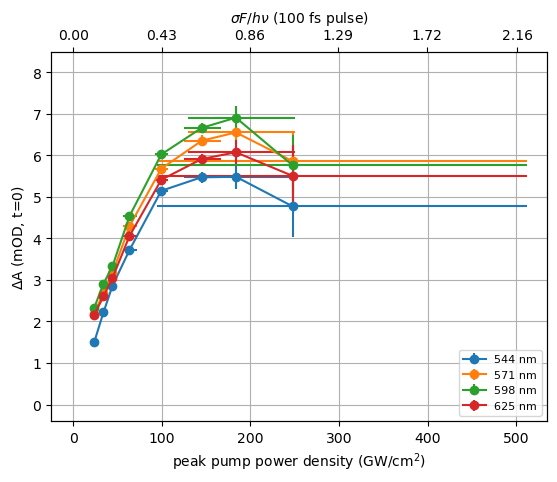

In [20]:
fig = plt.figure()
ax3 = fig.add_subplot(111)


time_start_cut = 12

amplitudes = []

for ix, wl_index in enumerate(wavelength_indices):

    wl_amplitudes = []
    x_errors = []
    y_errors = []
    corrected_powers = []

    for ip, power in enumerate(powers):

        times, dAs = load_raw(power, WAVELENGTH_SLICE)
        
        delta_A = dAs[:,wl_index]
        p_opt, p_err = curve_fit(expntl_t0,  times[time_start_cut:],  delta_A[time_start_cut:],  p0=p_ini)

        wl_amplitudes.append(p_opt[0])
        

        T = transmitted_powers[ip] / np.max(transmitted_powers)

        # fit error + absorbance error in quadrature (v rough)
        y_errors.append( np.sqrt(p_err[0,0] + np.square(-np.log10(T))) )

        corr = transmission_correction_factor(T)
        corrected_power = powers_in_GWcm2[ip] * corr
        
        x_errors.append([corrected_power-T * powers_in_GWcm2[ip], powers_in_GWcm2[ip]-corrected_power])
        corrected_powers.append(corrected_power)

    x_errors = np.array(x_errors)

    ax3.errorbar(corrected_powers, wl_amplitudes, fmt='o-', xerr=x_errors.T, yerr=y_errors)
    amplitudes.append(wl_amplitudes)



plt.gca().set_prop_cycle(None)


ax3.legend([f'{int(WAVELENGTHS[wi])} nm' for wi in wavelength_indices], loc=4, fontsize=8)
    
ax3.set_xlabel(r'peak pump power density (GW/cm$^2$)')
ax3.set_ylabel(r'$\Delta$A (mOD, t=0)')

x_min = -25
x_max = 535
ax3.set_xlim([x_min, x_max])

second_ax3 = ax3.twiny()

old_tick_locations = 100 * np.arange(7)

x_ticks = average_power_to_photons_per_molecule(old_tick_locations)
second_ax3.set_xticks([round(xt, 2) for xt in x_ticks])
second_ax3.set_xlabel(r'$\sigma F / h \nu$ (%d fs pulse)' % int(PULSE_DURATION * 1e15))
second_ax3.set_xlim(
    [
        average_power_to_photons_per_molecule(x_min),
        average_power_to_photons_per_molecule(x_max)
    ]
)

#ax3.text(-10, 6.2, '(C)', fontsize=18)
ax3.set_ylim([-0.4, 8.5])
ax3.grid()

plt.show()

## sanity check to ensure the exponential fitting is working...

45 1.0 [1.30151640e+00 5.70474288e-07]
45 2.0 [2.32572034e+00 5.27802053e-07]
45 3.0 [2.90769081e+00 5.12192039e-07]
45 4.0 [3.33008851e+00 4.92499934e-07]
45 6.0 [4.53374176e+00 5.79612556e-07]
45 9.0 [6.02175295e+00 5.63401317e-07]
45 14.0 [6.66175257e+00 5.65531354e-07]
45 21.0 [6.90746242e+00 5.75388465e-07]
45 43.0 [5.75749027e+00 5.21048239e-07]


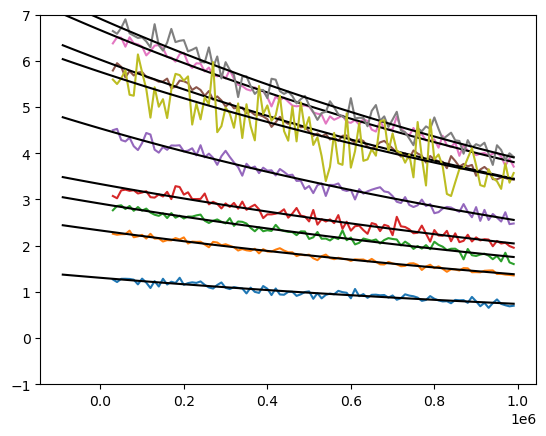

In [14]:
plt.figure()

wavelength_indices = [45]

for ix, wl_index in enumerate(wavelength_indices):
    for ip, power in enumerate(powers):

        times, dAs = load_raw(power, WAVELENGTH_SLICE)
        
        delta_A = dAs[:,wl_index]
        p_opt, _ = curve_fit(expntl_t0,  times[time_start_cut:],  delta_A[time_start_cut:],  p0=p_ini)
        print(wl_index, power, p_opt)

        plt.plot(times[time_start_cut:], delta_A[time_start_cut:])
        plt.plot(times, expntl_t0(times, *p_opt), 'k')

plt.ylim([-1,7])
plt.show()


## model fit testing

In [15]:
from importlib import reload 
reload(models)

<module 'models' from '/Users/tjlane/opt/mmcpd-scripts/models.py'>

(1, 9)
residual: 0.986681202419367
sigma_1, sigma_n: [0.05225531 0.02128028]
state populations at 358.8686868686869 GW/cm2 [0.43163954 0.33999506 0.2283654 ]


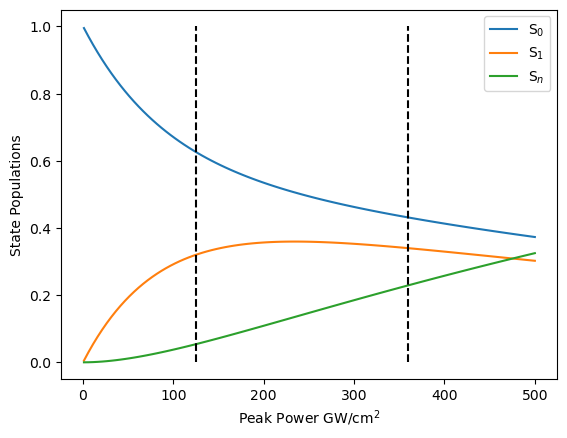

In [16]:
plt.figure()

amplitudes = []

for ix, wl_index in enumerate(wavelength_indices):

    wl_amplitudes = []

    for ip, power in enumerate(powers):
        times, dAs = load_raw(power, WAVELENGTH_SLICE)
        delta_A = dAs[:,wl_index]
        p_opt, _ = curve_fit(expntl_t0,  times[time_start_cut:],  delta_A[time_start_cut:],  p0=p_ini)
        wl_amplitudes.append(p_opt[0])

    amplitudes.append(wl_amplitudes)
    
amplitudes = np.array(amplitudes)
print(amplitudes.shape)

lp2 = models.LaserPower(
    pulse_length=0.1,
    powers=powers_in_GWcm2,
    absorbances=amplitudes
)
p_opt = lp2.fit(params0=[14.0, 14.0, 14.0, 14.0, 1.0, 0.1])

py = np.linspace(1, 500, 100)
lp2.powers = py
pred = np.outer(p_opt[:-2], lp2.estimate(*p_opt[-2:]))

# plt.plot(powers_in_GWcm2, amplitudes.T, 'o')
# plt.gca().set_prop_cycle(None)
# plt.plot(py, pred.T, '-')

power_index = 71

print('sigma_1, sigma_n:', p_opt[-2:])

lp2.pulse_length = 0.1

print(
    f'state populations at {py[power_index]} GW/cm2', 
    lp2.estimate(*p_opt[-2:], return_all_states=True)[power_index,:]
)

plt.plot(
    py,
    lp2.estimate(*p_opt[-2:], return_all_states=True)
)

plt.xlabel('Peak Power GW/cm$^2$')
plt.ylabel('State Populations')
plt.legend(['S$_0$', 'S$_1$', 'S$_n$'])

plt.vlines([125, 360], 0, 1, linestyles='--', color='k')
    
plt.show()
